In [1]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import json
import numpy as np
from operator import itemgetter

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
SCITSR_PATH = '/Users/longhoang/Developer/table-reg/data/SciTSR'
SCITSR_TRAIN = os.path.join(SCITSR_PATH, 'train')
SCITSR_TEST = os.path.join(SCITSR_PATH, 'test')

CHUNK_JSON_LABEL = '/Users/longhoang/Developer/table-reg/data/SciTSR/train/label/chunk_label.json'

In [3]:
TRAIN_IMG_DIR = os.path.join(SCITSR_TRAIN, 'img')
imgs_paths = [os.path.join(TRAIN_IMG_DIR, p) for p in os.listdir(TRAIN_IMG_DIR)]
len(imgs_paths)

12000

In [4]:
valid_imgs_paths = [p for p in imgs_paths if cv.imread(p) is not None]
len(valid_imgs_paths)

libpng error: Read Error
libpng error: Read Error
libpng error: Read Error
libpng error: Read Error
libpng error: Read Error
libpng error: Read Error


11971

In [5]:
def view_imgs(imgs):
    fig = plt.figure(figsize=(7,7))
    for i, img in enumerate(imgs):
        plt.subplot(1, len(imgs), i+1)
        if img.ndim == 3:
            if img.shape[-1] == 3:
                plt.imshow(img)
            else:
                plt.imshow(img[..., 0], cmap='gray', vmin=0, vmax=255)
        else:
            plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.show()

In [6]:
# load back ground truths for module Merge
MERGE_LABEL_PATH = os.path.join(SCITSR_TRAIN, 'label', 'merge_label.json')
with open(MERGE_LABEL_PATH, 'r') as f:
    merge_labels = json.load(f)
len(merge_labels)

11971

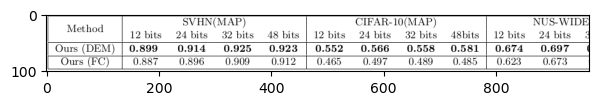

dtype('uint8')

In [52]:
idx = 44
def load_image(img_path):
    img = cv.imread(img_path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    return img

img_path = valid_imgs_paths[idx]
img = load_image(img_path).astype(np.uint8)
view_imgs([img])
img.dtype

In [53]:
def path2name(img_path):
    return os.path.splitext(os.path.basename(img_path))[0]

img_name = path2name(img_path)
img_name

'1504.03410v1.3'

In [54]:
gt = merge_labels[img_name]
rows, cols, R, D = gt['rows'], gt['columns'], gt['h_matrix'], gt['v_matrix']

rows, cols = np.array(rows), np.array(cols)
R, D = np.array(R), np.array(D)

In [55]:
h, w = len(rows), len(cols)
h, w

(101, 966)

In [56]:
img.shape

(101, 966, 3)

In [57]:
R.shape, D.shape

((4, 12), (3, 13))

In [58]:
cols.shape[0], rows.shape

(966, (101,))

In [59]:
rows_2d = np.tile(rows, (cols.shape[0], 1)).T
cols_2d = np.tile(cols, (rows.shape[0], 1))
rows_2d.shape, cols_2d.shape

((101, 966), (101, 966))

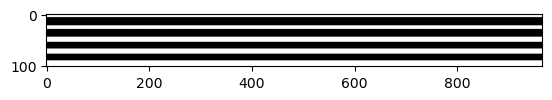

In [60]:
plt.imshow(rows_2d, cmap='gray')

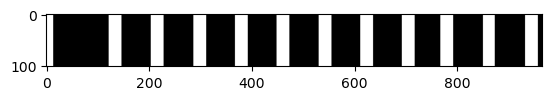

In [61]:
plt.imshow(cols_2d, cmap='gray')

In [62]:
mask = (cv.bitwise_or(rows_2d, cols_2d) * 255).astype(np.uint8)
# plt.imshow(mask, cmap='gray')
mask.min(), mask.max(), mask.dtype

(0, 255, dtype('uint8'))

(0, 255, dtype('uint8'))

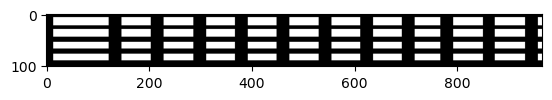

In [63]:
mask_inv = cv.bitwise_not(mask)
plt.imshow(mask_inv, cmap='gray')
mask_inv.min(), mask_inv.max(), mask_inv.dtype

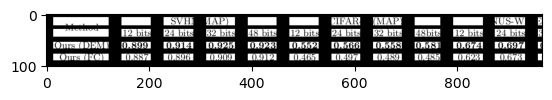

In [64]:
res = cv.bitwise_and(img, img, mask=mask_inv)
plt.imshow(res)

In [65]:
row_changes = np.array([abs(rows[i+1] - rows[i]) for i in range(len(rows) - 1)])
row_idxs = np.where(row_changes == 1)[0]

# check case where the first cell is right at the beginning of the row
if rows[0] == 0:  
    row_idxs = np.concatenate(([0], row_idxs))

# case where last cell right at the end of the row
if len(row_idxs) % 2 != 0:
    row_idxs = np.concatenate((row_idxs, [len(rows) - 1]))

row_idxs

array([ 5, 21, 28, 43, 53, 66, 76, 89])

In [66]:
col_changes = np.array([abs(cols[i+1] - cols[i]) for i in range(len(cols) - 1)])
col_idxs = np.where(col_changes == 1)[0]

if cols[0] == 0: 
    col_idxs = np.concatenate(([0], col_idxs))

if len(col_idxs) % 2 != 0:
    col_idxs = np.concatenate((col_idxs, [len(cols) - 1]))

col_idxs

array([ 13, 121, 146, 203, 228, 286, 311, 367, 392, 448, 473, 530, 555,
       611, 636, 692, 717, 767, 792, 850, 873, 932, 957, 965])

In [67]:
cells = []
for i in range(0, len(row_idxs), 2):
    for j in range(0, len(col_idxs), 2):
        top, left = row_idxs[i], col_idxs[j]
        if (i + 1) >= len(row_idxs) or (j + 1) >= len(col_idxs): 
            continue
        bottom, right = row_idxs[i+1], col_idxs[j+1]
        print(f'({top}, {left}), ({bottom}, {right})')
        cells.append(((top, left), (bottom, right)))

(5, 13), (21, 121)
(5, 146), (21, 203)
(5, 228), (21, 286)
(5, 311), (21, 367)
(5, 392), (21, 448)
(5, 473), (21, 530)
(5, 555), (21, 611)
(5, 636), (21, 692)
(5, 717), (21, 767)
(5, 792), (21, 850)
(5, 873), (21, 932)
(5, 957), (21, 965)
(28, 13), (43, 121)
(28, 146), (43, 203)
(28, 228), (43, 286)
(28, 311), (43, 367)
(28, 392), (43, 448)
(28, 473), (43, 530)
(28, 555), (43, 611)
(28, 636), (43, 692)
(28, 717), (43, 767)
(28, 792), (43, 850)
(28, 873), (43, 932)
(28, 957), (43, 965)
(53, 13), (66, 121)
(53, 146), (66, 203)
(53, 228), (66, 286)
(53, 311), (66, 367)
(53, 392), (66, 448)
(53, 473), (66, 530)
(53, 555), (66, 611)
(53, 636), (66, 692)
(53, 717), (66, 767)
(53, 792), (66, 850)
(53, 873), (66, 932)
(53, 957), (66, 965)
(76, 13), (89, 121)
(76, 146), (89, 203)
(76, 228), (89, 286)
(76, 311), (89, 367)
(76, 392), (89, 448)
(76, 473), (89, 530)
(76, 555), (89, 611)
(76, 636), (89, 692)
(76, 717), (89, 767)
(76, 792), (89, 850)
(76, 873), (89, 932)
(76, 957), (89, 965)


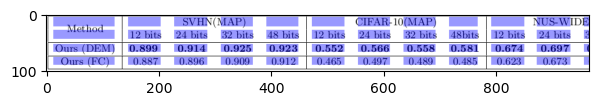

In [68]:
img_boxes = img.copy()

for (t, l), (b, r) in cells:
    cv.rectangle(img_boxes, (l, t), (r, b), (0, 0, 255), -1)
res = cv.addWeighted(img_boxes, 0.4, img, 0.6, 0)

view_imgs([res])

In [69]:
with open(CHUNK_JSON_LABEL, 'r') as f:
    chunk_labels = json.load(f)

len(chunk_labels)

11971

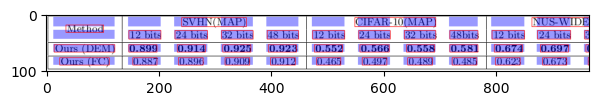

In [70]:
img2 = res.copy()

for text, (l, t, r, b) in chunk_labels[img_name]:
    cv.rectangle(img2, (l, t), (r, b), (255, 0, 0), 1)

view_imgs([img2])

`Rule 1:` Merge cells where predicted seperator passes through text

In [71]:
num_rows = round(len(row_idxs) / 2)
num_cols = round(len(col_idxs) / 2)

num_rows, num_cols

(4, 12)

In [72]:
R_pred = np.zeros((num_rows, num_cols-1), dtype=np.uint8) # merge RIGHT matrix
D_pred = np.zeros((num_rows-1, num_cols), dtype=np.uint8) # merge DOWN matrix

R_pred.shape, D_pred.shape

((4, 11), (3, 12))

Find the Right and Down neighbor of a cell

In [73]:
idx = 0
cell = cells[idx]

cell

((5, 13), (21, 121))

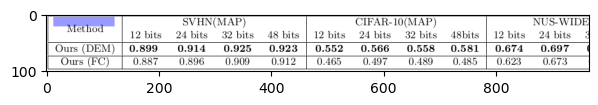

In [74]:
img3 = img.copy()

(t, l), (b, r) = cell
cv.rectangle(img3, (l, t), (r, b), (0, 0, 255), -1)
img_1cell = cv.addWeighted(img3, 0.4, img, 0.6, 0)

view_imgs([img_1cell])

In [75]:
def id2coord(id, n_cols):
    x = id // n_cols
    y = id % n_cols
    return x, y

In [76]:
def neighbor_RD(idx, num_rows, num_cols):
    idx_right = idx + 1 if (idx + 1) % num_cols != 0 else None
    idx_down = idx + num_cols if (idx + num_cols) < (num_rows * num_cols) else None
    return idx_right, idx_down

In [77]:
rn, dn = neighbor_RD(idx, num_rows, num_cols)
rn, dn

(1, 12)

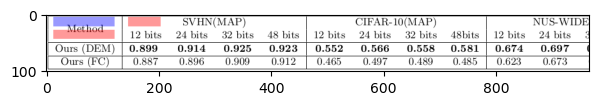

In [78]:
img4 = img.copy()
cv.rectangle(img4, (l, t), (r, b), (0, 0, 255), -1)

if rn:
    (t1, l1), (b1, r1) = cells[rn]
    cv.rectangle(img4, (l1, t1), (r1, b1), (255, 0, 0), -1)
if dn:
    (t2, l2), (b2, r2) = cells[dn]
    cv.rectangle(img4, (l2, t2), (r2, b2), (255, 0, 0), -1)

img_3cell = cv.addWeighted(img4, 0.4, img, 0.6, 0)
view_imgs([img_3cell])

In [79]:
# NOTE: these two functions are not quite efficient yet
def check_merge_right(id, id_r, cells, chunks):
    (top, left), (bottom, right) = cells[id]
    (_, left_r), (_, right_r) = cells[id_r]
    for text, (l, t, r, b) in chunks:
        if l < right and left_r < r and \
            (top < t < bottom or top < b < bottom):
            return True
    return False

def check_merge_down(id, id_d, cells, chunks):
    (top, left), (bottom, right) = cells[id]
    (top_d, _), (bottom_d, _) = cells[id_d]
    for text, (l, t, r, b) in chunks:
        if t < bottom and top_d < b and \
            (left < l < right or left < r < right):
            return True
    return False

In [80]:
chunks = chunk_labels[img_name]

In [81]:
id = 2
rn, _ = neighbor_RD(id, num_rows, num_cols)

check_merge_right(id, rn, cells, chunks)

True

In [82]:
id = 0
_, dn = neighbor_RD(id, num_rows, num_cols)

check_merge_down(id, dn, cells, chunks)

True

In [83]:
for id, cell in enumerate(cells):
    merge_right, merge_down = None, None
    x, y = id2coord(id, num_cols)

    (t, l), (b, r) = cell
    rn, dn = neighbor_RD(id, num_rows, num_cols)
    if rn:
        merge_right = check_merge_right(id, rn, cells, chunks)
        if merge_right: 
            R_pred[x, y] = 1
            print(f'Merge right at cell ({x},{y})')
    if dn:
        merge_down = check_merge_down(id, dn, cells, chunks)
        if merge_down: 
            D_pred[x, y] = 1
            print(f'Merge down at cell ({x},{y})')
            
    # print(f'Cell ({x}, {y}) | Merge right: {merge_right} | Merge down: {merge_down}')

Merge down at cell (0,0)
Merge right at cell (0,2)
Merge right at cell (0,6)
Merge right at cell (0,10)


In [84]:
R_pred

array([[0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=uint8)

In [85]:
D_pred

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=uint8)

`Rule 2:` In the first row (likely header row), merge non-blank cells with adjacent blank cells

In [86]:
def is_blank(id, cells, chunks):
    (top, left), (bottom, right) = cells[id]
    for text, (l, t, r, b) in chunks:
        if (top < b and bottom > t) and (left < r and right > l):
            return False
    return True

In [87]:
for id, cell in enumerate(cells):
    x, y = id2coord(id, num_cols)
    type_ = 'blank' if is_blank(id, cells, chunks) else 'non-blank'
    # print(f'Cell ({x},{y}): {type_}')

In [88]:
# NOTE: currently only merge right for cells in the first
#       row if its right neighbour is blank to avoid ambiguity

for id, cell in enumerate(cells):
    x, y = id2coord(id, num_cols)
    rn, dn = neighbor_RD(id, num_rows, num_cols)

    if x == 0 and rn: # first row and has right neighbour
        # if right cell is blank and current cell is non-blank, merge right
        if not is_blank(id, cells, chunks) and is_blank(rn, cells, chunks):
            R_pred[x, y] = 1
            print(f'Merge right at cell ({x},{y})')

Merge right at cell (0,0)
Merge right at cell (0,3)
Merge right at cell (0,7)


In [89]:
R_pred

array([[1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=uint8)

In [90]:
D_pred

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=uint8)

In [91]:
(R != R_pred).sum()

ValueError: operands could not be broadcast together with shapes (4,12) (4,11) 

In [ ]:
(D != D_pred).sum()

0